In [451]:
# imports

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
import numpy as np
import sympy as sp
import pandas as pd

In [417]:
plt.style.use(["bmh"])
np.set_printoptions(threshold=np.inf, precision=4, suppress=False)

In [418]:
# functions

def make_Ki_vector(N, ko, kp, ka, sigma=0):
    "make vector Ko, Kp, Ka of each node"
    "Parameters: sigma = random number"
    Ko = np.random.normal(ko, sigma, N)
    Kp = np.random.normal(kp, sigma, N)
    Ka = np.random.normal(ka, sigma, N)

    return Ko, Kp, Ka

def make_K_matrix(Ko, Kp, Ka):
    "make stiffness matrix for torsional spring"
    N = np.shape(Ko)[0]
    K = np.zeros((N, N), dtype=float)

    for i in range(N):
        K[i, (i - 1) % N] = Kp[(i - 1) % N] + Ka[(i - 1) % N]
        K[i, i] = Ko[i]
        K[i, (i + 1) % N] = Kp[i % N] - Ka[i % N]

    return K

def find_equilibrium(K, D, fixed_nodes, N):
    def loop_equation(i, N, type):
        polytheta = np.pi - (N - 2) * np.pi / N
        sum_theta = [
            sp.Add(*[val + polytheta for val in D_sym[1 : j + 2]]) for j in range(i, N)
        ]
        sum_theta = list(
            dict.fromkeys(sum_theta)
        )  # Remove any potential duplicates from sum_theta
        if type == "sin":
            loop = [sp.sin(val) for val in sum_theta]
        else:
            loop = [sp.cos(val) for val in sum_theta]
        loop_final = sum(loop)
        return loop_final

    def solve():
        tolerance = 1e-6
        max_attempts = 5  # Maximum number of attempts to decrease tolerance
        attempt = 0

        while attempt < max_attempts:
            try:
                solutions = sp.nsolve(equations, variables, guess, tol=tolerance)
                break  # If successful, break out of the loop
            except ValueError as e:
                if "Could not find root within given tolerance" in str(e):
                    # Double the precision by halving the tolerance
                    tolerance *= 10
                    attempt += 1
                    print("tolerance decrease since solution could not find. ")
                else:
                    raise  # If the error is not related to tolerance, raise it
        else:
            # This block will run if the loop completes without finding a solution
            raise ValueError(
                "Could not find a solution even after decreasing tolerance."
            )
        return solutions

    L = 1  # lengthS
    nodes = np.arange(0, N)
    fixed_nodes = np.sort(fixed_nodes)  # fixed nodes
    nodes = np.delete(nodes, fixed_nodes)  # free nodes

    D_sym = sp.symbols("D0:%d" % N)  # create D_0 ... D_N
    K_sym = sp.Matrix(K)

    "Lagrange multiplier"
    a = sp.symbols("a0:%d" % len(fixed_nodes))  # fixed angle
    b = sp.symbols("b")  # sum of angles
    c = sp.symbols("c")  # x_0 == 0
    d = sp.symbols("d")  # y_0 == 0

    equations = []
    j = 0  # fixed node id

    for i in range(N):
        equation = K_sym.row(i).dot(D_sym) + b  # Common part

        if i != 0:  # for i!=0 node, add constraint (x0, y0)==0
            equation -= c * L * loop_equation(i - 1, N, type="sin")
            equation += d * L * loop_equation(i - 1, N, type="cos")

        if i in fixed_nodes:  # for fixed node, add constrain D[i] = constant
            equation += a[j]
            j += 1

        equations.append(sp.Eq(equation, 0))

    for _, fi in enumerate(fixed_nodes):
        equations.append(sp.Eq(D_sym[fi], D[fi]))
    equations.append(sp.Eq(sp.Add(*D_sym), 0))
    equations.append(sp.Eq(L + L * loop_equation(0, N, type="cos"), 0))
    equations.append(sp.Eq(L * loop_equation(0, N, type="sin"), 0))

    multiplier_guess = [0.0] * (len(fixed_nodes) + 3)
    De_guess = [0.1] * N
    guess = De_guess + multiplier_guess
    variables = list(D_sym) + list(a) + [b] + [c] + [d]
    solutions = solve()

    De = [solutions[i] for i in range(N)]
    De = [
        float(val) for val in De
    ]  # Convert SymPy Float objects to native Python floats
    multiplier = solutions[:-4]

    "convert list to numpy array"
    De = np.array(De)
    multiplier = np.array(multiplier)
    return De

def update_k(K, Ko, Kp, Ka, kodot, kpdot, kadot):
    N = np.shape(K)[0]
    for i in range(N):
        Ko[i] += kodot[i]
        Kp[i] += kpdot[i]
        Ka[i] += kadot[i]
    K = make_K_matrix(Ko, Kp, Ka)

    return K, Ko, Kp, Ka

def append_target_df(df_name, DI_id, DI_val, DT_id, DT_val):

    df_name.loc[len(df_name)] = [DI_id, DI_val, DT_id, DT_val]

    return df_name


def new_target_df():

    df_name = pd.DataFrame(columns=['Input ID', 'Input value', 'Target ID', 'Target value'])
    return df_name


def convert_Dval(D_val_all, D_id_all, target_id, N):
    D = np.zeros((1, N))
    D[:, D_id_all[target_id]] = D_val_all[target_id]
    return D.reshape(
        N,
    )

In [419]:
# function with the stability constraints
def make_kdot(K, Ko, Kp, Ka, DF, DC, lr, direction):
    N = np.shape(DF)[0]
    I = np.zeros_like(K)
    np.fill_diagonal(I, 1)
    Ir = np.roll(I, -1, axis=0)
    Il = np.roll(I, 1, axis=0)

    "rotation of free state"
    DFil = np.dot(Il, DF)  # DF[i-1]
    DFi = np.dot(I, DF)  # DF[i]
    DFir = np.dot(Ir, DF)  # DF[i+1]
    "clamped rotation"
    DCil = np.dot(Il, DC)  # DC[i-1]
    DCi = np.dot(I, DC)  # DC[i]
    DCir = np.dot(Ir, DC)  # DC[i+1]

    grad_ko = (np.square(DFi) - np.square(DCi)) * 0.5
    grad_kp = DFi * DFir - DCi * DCir
    grad_ka = -(DFi * DFir - DCi * DCir) * direction

    kodot = lr * grad_ko
    kpdot = lr * grad_kp
    kadot = lr * grad_ka

    def stability_constraint(Ko, Kp, Ka):
        for i in range(N):
            # the updated parameters
            Ko_ = Ko[i] + kodot[i]
            Kp_ = Kp[i] + kpdot[i]
            Ka_ = Ka[i] + kadot[i]
            Ki = Ko_
            Kil = Kp_ + Ka_
            kir = Kp_ - Ka_

            # Gershgorin disk
            Ci = Ki  # the center of ith disk
            Ri = abs(Kil) + abs(kir)  # the radius of ith disk
            Stable = (
                Ci > 0 and (Ri - Ci) < 0
            )  # if yield, the real part of ith eigenvalue is positive

            if not Stable:
                # kodot[i] = 0
                # kpdot[i] = 0
                kadot[i] = 0

    stability_constraint(Ko, Kp, Ka)

    return kodot, kpdot, kadot

In [420]:
# variables

N = 6  
Nsteps = 20 
Koi, Kpi, Kai = (
    0.05,
    0.01,
    0.00,
)

In [421]:
# learning rate

eta = 1  
alpha = 0.002 
lr = alpha / eta

In [422]:
#simulation

# initials
def Simulation(N, Nsteps, Koi, Kpi, Kai, lr, target_df):
    Ntarget = np.shape(target_df['Input ID'])[0]
    print(f'Number of targets: {Ntarget}')
    K_step = np.zeros((N, N, Nsteps + 1))  # the stiffness materix of each steps
    Ko_step = np.zeros((Nsteps + 1, N))
    Kp_step = np.zeros((Nsteps + 1, N))
    Ka_step = np.zeros((Nsteps + 1, N))
    DF_step = np.zeros(
        (Nsteps + 1, N, Ntarget)
    )  # the angle deflecton of the free state in each step
    eigvals_step = np.zeros(
        (Nsteps + 1, N), dtype=np.complex64
    )  # eigenvalues of stiffness matrix in each steps
    Error_step = np.zeros((Nsteps, Ntarget))

    Ko, Kp, Ka = make_Ki_vector(N, Koi, Kpi, Kai, sigma=0)
    K = make_K_matrix(Ko, Kp, Ka)
    print("Stiffness Matrix K = \n", K)

    "initial values"
    K_step[:, :, 0] = K
    Ko_step[0, :] = Ko
    Kp_step[0, :] = Kp
    Ka_step[0, :] = Ka
    eigvals_step[0, :] = np.sort(np.linalg.eigvals(K))

    Errors_final  = np.zeros((1, Ntarget))
    Errors_10step = np.zeros((1, Ntarget))

    #----------------------------------------------------------------------------
    #                              simulation loop
    #----------------------------------------------------------------------------

    for i in range(Ntarget):
        DF_step[0, :, i] = convert_Dval(target_df['Input value'], target_df['Input ID'], i, N)
    Error = 0
    for step in range(Nsteps):
        if (step + 1) % 10 == 0:
            print("Current step: {} / {}".format(step + 1, Nsteps))
        for target in range(Ntarget):

            if (step + 1) % 10 == 0:
                print(f'Error {target + 1}: {Error}')
                
            DI = convert_Dval(target_df['Input value'], target_df['Input ID'], target, N)
            DT = convert_Dval(target_df['Target value'], target_df['Target ID'], target, N)

            nodesI = target_df.iloc[target]['Input ID']
            nodesT = target_df.iloc[target]['Target ID']
            d = np.sign(max(nodesI) - min(nodesT))

            "nodes fixed in clamped state"
            nodesC = np.sort(np.concatenate((nodesI, nodesT)))

            "find initial free states"
            "if equilibrium has value error, stop the step loop."
            try: 
                DF = find_equilibrium(K, DI, nodesI, N)
                DF_step[step + 1, :, target] = DF

            except ValueError:
                Errors_final[0, target] = ('NaN')
                break

            " calculate the error"
            Error = np.sum((DF[nodesT] - DT[nodesT]) ** 2)
            Error_step[step, target] = Error

            if step + 1 == (Nsteps):
                Errors_final[0, target] = Error_step[step, target]

            if step + 1 == 10:
                Errors_10step[0, target] = Error_step[step, target]

            "define nudge rotation vector DN"
            DN = np.copy(DI)
            DN[nodesT] = DF[nodesT] + 1 * (DT[nodesT] - DF[nodesT]) # 1 = eta

            "clamped state"
            DC = find_equilibrium(K, DN, nodesC, N)

            "update stiffness matrix"
            kodot, kpdot, kadot = make_kdot(
                K, Ko, Kp, Ka, DF, DC, lr, direction=d
            )  # --------------------------------
            (
                K,
                Ko,
                Kp,
                Ka,
            ) = update_k(K, Ko, Kp, Ka, kodot, kpdot, kadot)

        K_step[:, :, step + 1] = K
        Ko_step[step + 1, :] = Ko
        Kp_step[step + 1, :] = Kp
        Ka_step[step + 1, :] = Ka
        eigvals_step[step + 1, :] = np.sort(np.linalg.eigvals(K))

    np.save("./K_step.npy", K_step)
    np.save("./Ko_step.npy", Ko_step)
    np.save("./Kp_step.npy", Kp_step)
    np.save("./Ka_step.npy", Ka_step)
    np.save("./DF_step.npy", DF_step)
    np.save("./Error_step.npy", Error_step)

    print("Final Stiffness Matrix K = \n", K)
    print("Onsite Passive Stiffness Matrix K = \n", Ko)
    print("Symmetric Passive Stiffness Matrix K = \n", Kp)
    print("Active Stiffness Matrix K = \n", Ka)
    print("Eigenvalues = \n", eigvals_step[-1, :])

    # return Ntarget, Error_step, DF_step, Ko_step, Kp_step, Ka_step, eigvals_step
    return Ntarget, Errors_final, Errors_10step

In [423]:
def Simulation_Vis(N, Nsteps, Koi, Kpi, Kai, lr, target_df):
    Ntarget = np.shape(target_df['Input ID'])[0]
    print(Ntarget)
    K_step = np.zeros((N, N, Nsteps + 1))  # the stiffness materix of each steps
    Ko_step = np.zeros((Nsteps + 1, N))
    Kp_step = np.zeros((Nsteps + 1, N))
    Ka_step = np.zeros((Nsteps + 1, N))
    DF_step = np.zeros(
        (Nsteps + 1, N, Ntarget)
    )  # the angle deflecton of the free state in each step
    eigvals_step = np.zeros(
        (Nsteps + 1, N), dtype=np.complex64
    )  # eigenvalues of stiffness matrix in each steps
    Error_step = np.zeros((Nsteps, Ntarget))

    Ko, Kp, Ka = make_Ki_vector(N, Koi, Kpi, Kai, sigma=0)
    K = make_K_matrix(Ko, Kp, Ka)
    print("Stiffness Matrix K = \n", K)

    "initial values"
    K_step[:, :, 0] = K
    Ko_step[0, :] = Ko
    Kp_step[0, :] = Kp
    Ka_step[0, :] = Ka
    eigvals_step[0, :] = np.sort(np.linalg.eigvals(K))

    Errors_final = np.zeros((1, Ntarget))

    #----------------------------------------------------------------------------
    #                              simulation loop
    #----------------------------------------------------------------------------

    for i in range(Ntarget):
        DF_step[0, :, i] = convert_Dval(target_df['Input value'], target_df['Input ID'], i, N)
    Error = 0
    for step in range(Nsteps):
        if (step + 1) % 10 == 0:
            print("Current step: {} / {}".format(step + 1, Nsteps))
            print(Error)
        for target in range(Ntarget):
            DI = convert_Dval(target_df['Input value'], target_df['Input ID'], target, N)
            DT = convert_Dval(target_df['Target value'], target_df['Target ID'], target, N)

            nodesI = target_df.iloc[target]['Input ID']
            nodesT = target_df.iloc[target]['Target ID']
            d = np.sign(max(nodesI) - min(nodesT))

            "nodes fixed in clamped state"
            nodesC = np.sort(np.concatenate((nodesI, nodesT)))

            "find initial free states"
            "if equilibrium has value error, stop the step loop."
            try: 
                DF = find_equilibrium(K, DI, nodesI, N)
                DF_step[step + 1, :, target] = DF

            except ValueError:
                Errors_final[0, target] = ('NaN')
                break

            " calculate the error"
            Error = np.sum((DF[nodesT] - DT[nodesT]) ** 2)
            Error_step[step, target] = Error

            print(target)
            print(Error)

            if step + 1 == (Nsteps):
                Errors_final[0, target] = Error_step[step, target]

            "define nudge rotation vector DN"
            DN = np.copy(DI)
            DN[nodesT] = DF[nodesT] + 1 * (DT[nodesT] - DF[nodesT]) # 1 = eta

            "clamped state"
            DC = find_equilibrium(K, DN, nodesC, N)

            "update stiffness matrix"
            kodot, kpdot, kadot = make_kdot(
                K, Ko, Kp, Ka, DF, DC, lr, direction=d
            )  # --------------------------------
            (
                K,
                Ko,
                Kp,
                Ka,
            ) = update_k(K, Ko, Kp, Ka, kodot, kpdot, kadot)

        K_step[:, :, step + 1] = K
        Ko_step[step + 1, :] = Ko
        Kp_step[step + 1, :] = Kp
        Ka_step[step + 1, :] = Ka
        eigvals_step[step + 1, :] = np.sort(np.linalg.eigvals(K))

    np.save("./K_step.npy", K_step)
    np.save("./Ko_step.npy", Ko_step)
    np.save("./Kp_step.npy", Kp_step)
    np.save("./Ka_step.npy", Ka_step)
    np.save("./DF_step.npy", DF_step)
    np.save("./Error_step.npy", Error_step)

    print("Final Stiffness Matrix K = \n", K)
    print("Onsite Passive Stiffness Matrix K = \n", Ko)
    print("Symmetric Passive Stiffness Matrix K = \n", Kp)
    print("Active Stiffness Matrix K = \n", Ka)
    print("Eigenvalues = \n", eigvals_step[-1, :])

    return Ntarget, Error_step, DF_step, Ko_step, Kp_step, Ka_step, eigvals_step

In [424]:
# visualization

def visualization(Ntarget, Error_step, DF_step, Ko_step, Kp_step, Ka_step, eigvals_step):
    font = 15
    f, ax = plt.subplots(1, 1)
    "error over time"
    for i in range(Ntarget):
        ax.plot(np.arange(Nsteps), Error_step[:, i], label="target {}".format(i + 1))
    ax.set_xlabel("Steps", fontsize=font)
    ax.set_ylabel("Error", fontsize=font)
    ax.set_yscale("log")
    ax.legend()
    plt.show()

    "angle over time"
    f, ax = plt.subplots(1, Ntarget)
    if Ntarget > 1:
        for i in range(Ntarget):
            for j in range(N):
                ax[i].plot(
                    np.arange(Nsteps + 1),
                    DF_step[:, j, i] * (180 / np.pi),
                    label=r"$\theta_{{{}}}$".format(j + 1),
                )
                ax[i].set_xlabel("Steps", fontsize=font)
                ax[i].set_ylabel(r"Angle ($\circ$)", fontsize=font)
                ax[i].legend(fontsize=font)
                ax[i].set_title("Target {}".format(i + 1))
                ax[i].legend()
    else:
        for j in range(N):
            ax.plot(
                np.arange(Nsteps + 1),
                DF_step[:, j, i] * (180 / np.pi),
                label=r"$\theta_{{{}}}$".format(j + 1),
            )
            ax.set_xlabel("Steps", fontsize=font)
            ax.set_ylabel(r"Angle ($\circ$)", fontsize=font)
            ax.legend(fontsize=font)
            ax.set_title("Target {}".format(i + 1))
            ax.legend()
    plt.show()

    "stiffnesses over time"
    f, ax = plt.subplots(1, 1)
    for i in range(N):
        ax.plot(
            np.arange(Nsteps + 1),
            Ko_step[:, i],
            label=r"$k_{{{}}}^{{o}}$".format(i + 1),
        )
    for i in range(N - 1):
        ax.plot(
            np.arange(Nsteps + 1),
            Kp_step[:, i],
            label=r"$k_{{{}}}^{{p}}$".format(i + 1),
        )
        ax.plot(
            np.arange(Nsteps + 1),
            Ka_step[:, i],
            label=r"$k_{{{}}}^{{a}}$".format(i + 1),
        )
    ax.set_xlabel("Steps", fontsize=font)
    ax.set_ylabel(r"Stiffnesses $k_{i}$", fontsize=font)
    ax.legend(fontsize=font, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=5)
    plt.show()

    "plot eigenvalues"
    f, ax = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(N):
        ax[0].plot(np.real(eigvals_step[:, i]), label=r"$\lambda_{}$".format(i + 1))
    # ax.axhline(y=0, ls="--", c='#000000')
    ax[0].set_ylabel(r"Re($\lambda$)", fontsize=font)
    ax[0].legend()

    for i in range(N):
        ax[1].plot(np.imag(eigvals_step[:, i]), label=r"$\lambda_{}$".format(i + 1))
    # ax.axhline(y=0, ls="--", c='#000000')
    ax[1].set_xlabel("Steps", fontsize=font)
    ax[1].set_ylabel(r"Im($\lambda$)", fontsize=font)
    ax[1].legend()
    plt.show()

    # visulization
    def show_bar(D, nodesI, nodesT, target):
        "Plot mass-bar structure"

        N = np.shape(D)[0]
        polytheta = (180 - (N - 2) * 180 / N) * (np.pi / 180)
        L = 1
        P = np.arange(0, N, L)

        print("Displacement in degrees")
        print(D * (180 / np.pi))

        "new locations"
        Pxy = np.zeros((N, 2))
        Pxy[:, 0] = P
        theta = 0.0
        for i in range(1, N):
            theta += D[i - 1]
            Pxy[i, 0] = Pxy[i - 1, 0] + L * (np.cos(theta + polytheta * (i - 1)))
            Pxy[i, 1] = Pxy[i - 1, 1] + L * (np.sin(theta + polytheta * (i - 1)))

        # add the last bar information
        Pxy = np.append(Pxy, [[0, 0]], axis=0)

        # create a new subplot
        _, ax_sub = plt.subplots(1, 1)
        # plot the bars
        t = 1
        ax_sub.plot(Pxy[:, 0], Pxy[:, 1], lw=3, alpha=t, color="#87CEFA")

        # plot the masses
        size = 200
        ax_sub.scatter(
            Pxy[:, 0],
            Pxy[:, 1],
            marker="o",
            s=size,
            facecolor="w",
            edgecolors="k",
            linewidth=2,
            alpha=t,
            zorder=2,
        )
        ax_sub.scatter(
            Pxy[0],
            Pxy[0],
            marker="o",
            s=size,
            facecolor="#228B22",
            edgecolors="k",
            alpha=t,
            zorder=2,
        )  # inputs:first
        ax_sub.scatter(
            Pxy[nodesI, 0],
            Pxy[nodesI, 1],
            marker="o",
            s=size,
            facecolor="#FF8C00",
            edgecolors="k",
            alpha=t,
            zorder=2,
        )  # inputs:orange
        ax_sub.scatter(
            Pxy[nodesT, 0],
            Pxy[nodesT, 1],
            marker="o",
            s=size,
            facecolor="#B22222",
            edgecolors="k",
            alpha=t,
            zorder=2,
        )  # outputs:red

        # configure the axes
        ax_sub.axis("equal")
        ax_sub.set_xlim(Pxy[:, 0].min() - 1, Pxy[:, 0].max() + 1)
        ax_sub.set_ylim(Pxy[:, 1].min() - 1, Pxy[:, 1].max() + 1)
        ax_sub.set_axis_off()
        ax_sub.set_title("Target {}".format(target + 1))
        ax_sub.axis("equal")

        return ax

    "plot the ids_th structure"
    fig, ax = plt.subplots(Ntarget, 1)
    if Ntarget > 1:
        for i in range(Ntarget):
            nodesI = DI_id_all[i] 
            nodesT = DT_id_all[i]
            DF_final = DF_step[-1, :, i]
            ax[i] = show_bar(DF_final, nodesI, nodesT, i)
    else:
        nodesI = DI_id_all[0]
        nodesT = DT_id_all[0]
        DF_final = DF_step[-1, :, 0]
        ax = show_bar(DF_final, nodesI, nodesT, 0)
    plt.show()

In [425]:
# TEST: defining the targets

sim1_targets = new_target_df()

"target 1"
" the angles are exterior angles"
DI_id = np.array([0])  
DI_val = np.array([60]) * (np.pi / 180)
DT_id = np.array([3])  
DT_val = np.array([180]) * (np.pi / 180) 

" because the reference configuration is a regular polygon, the angluar difference of each unit should minus the exterior angle of this polygon"
polytheta = (N - 2) * np.pi / N  # Exterior angles of a regular N-gon
DI_val = polytheta - DI_val
DT_val = polytheta - DT_val
append_target_df(sim1_targets, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

"target 2"
" the angles are exterior angles"
DI_id = np.array([3])  
DI_val = np.array([60]) * (np.pi / 180)
DT_id = np.array([0])  
DT_val = np.array([180]) * (np.pi / 180) 

" because the reference configuration is a regular polygon, the angluar difference of each unit should minus the exterior angle of this polygon"
polytheta = (N - 2) * np.pi / N  # Exterior angles of a regular N-gon
DI_val = polytheta - DI_val
DT_val = polytheta - DT_val

append_target_df(sim1_targets, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

,Input ID,Input value,Target ID,Target value
0,[0],[1.0471975511965976],[3],[-1.0471975511965979]
1,[3],[1.0471975511965976],[0],[-1.0471975511965979]


In [426]:
# TEST SIM
# Ntarget, Error_step, DF_step, Ko_step, Kp_step, Ka_step, eigvals_step = Simulation_Vis(N=N, Nsteps=Nsteps, Koi=Koi, Kpi=Kpi, Kai=Kai, lr=lr, target_df=sim1_targets)

In [427]:
# TEST
#visualization(Ntarget, Error_step, DF_step, Ko_step, Kp_step, Ka_step, eigvals_step)

In [428]:
Nlist = [6, 7, 8, 9, 10, 11, 12]
Ntargets_2T = []
N_vs_Err_2T_10 = np.zeros((len(Nlist), 2))
N_vs_Err_2T_20 = np.zeros((len(Nlist), 2))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_2T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_2T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_2T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_2T)
    Ntargets_2T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_2T_10[count, i] = Errors_10[0, i]
        N_vs_Err_2T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 6
Number of targets: 2
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.09235740309142995
Error 2: 0.0018003886568238722
Current step: 20 / 20
Error 1: 8.457169670603152e-05
Error 2: 1.2700279087941348e-05
Final Stiffness Matrix K = 
 [[0.0497 0.01   0.     0.     0.     0.0198]
 [0.0098 0.0503 0.01   0.     0.     0.    ]
 [0.     0.0281 0.0422 0.0143 0.     0.    ]
 [0.     0.     0.0388 0.0431 0.0106 0.    ]
 [0.     0.     0.     0.0296 0.0485 0.013 ]
 [0.01   0.     0.     0.     0.0234 0.0462]]
Onsite Passive Stiffness Matrix K = 
 [0.0497 0.0503 0.0422 0.0431 0.0485 0.0462]
Symmetric Passive Stiffness Matrix K = 
 [0.0099 0.0191 0.0265 0.0201 0.0182 0.0149]
Active Stiffness Matrix K = 
 [-0.0001  0.0091  0.0123  0.0095  0.0052  0.0049]
Eigenvalues = 
 [0.0085+0.j 

ValueError: Could not find a solution even after decreasing tolerance.

In [429]:
Nlist = [6, 7, 8, 9, 10, 11, 12]
Ntargets_1T = []
N_vs_Err_1T_10 = np.zeros((len(Nlist), 1))
N_vs_Err_1T_20 = np.zeros((len(Nlist), 1))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_1T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(df_name=targets_1T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_1T)
    Ntargets_1T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_1T_10[count, i] = Errors_10[0, i]
        N_vs_Err_1T_20[count, i] = Errors_20[0, i]

    count += 1

System size: 6
Number of targets: 1
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.0003932607432489302
Current step: 20 / 20
Error 1: 1.1917144382221396e-15
Final Stiffness Matrix K = 
 [[0.05   0.01   0.     0.     0.     0.0192]
 [0.0113 0.0494 0.01   0.     0.     0.    ]
 [0.     0.0273 0.0443 0.0125 0.     0.    ]
 [0.     0.     0.0345 0.0432 0.0135 0.    ]
 [0.     0.     0.     0.0369 0.0425 0.0133]
 [0.01   0.     0.     0.     0.0352 0.0455]]
Onsite Passive Stiffness Matrix K = 
 [0.05   0.0494 0.0443 0.0432 0.0425 0.0455]
Symmetric Passive Stiffness Matrix K = 
 [0.0107 0.0186 0.0235 0.0252 0.0242 0.0146]
Active Stiffness Matrix K = 
 [0.0007 0.0086 0.011  0.0117 0.011  0.0046]
Eigenvalues = 
 [0.0049+0.j     0.0282-0.0103j 0.0282+0.0103j 0.0646-0.0114j
 0.0646+0.0114j 0

In [458]:
# Nlist = [6, 7, 8, 9, 10, 11, 12]
# Ntargets_2T_other = []
# N_vs_Err_2T_10_other = np.zeros((len(Nlist), 2))
# N_vs_Err_2T_20_other = np.zeros((len(Nlist), 2))

# count = 0
# for N in Nlist:

#     print(f'System size: {N}')

#     targets_2T_other= new_target_df()
    
#     DI_id = np.array([0])  
#     DI_val = np.array([60]) * (np.pi / 180)
#     DT_id = np.array([3])  
#     DT_val = np.array([-60]) * (np.pi / 180)

#     append_target_df(targets_2T_other, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

#     DI_id = np.array([3])  
#     DI_val = np.array([60]) * (np.pi / 180)
#     DT_id = np.array([0])  
#     DT_val = np.array([-60]) * (np.pi / 180)
    
#     append_target_df(targets_2T_other, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
#     Ntargets_other, Errors_20_other, Errors_10_other = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_2T_other)
#     Ntargets_2T_other.append(Ntargets)
#     for i in range(Ntargets):

#         N_vs_Err_2T_10_other[count, i] = Errors_10_other[0, i]
#         N_vs_Err_2T_20_other[count, i] = Errors_20_other[0, i]


#     count += 1

System size: 6
Number of targets: 2
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 1.1649930993184019e-07
Error 2: 6.094339434921417e-09
Current step: 20 / 20
Error 1: 2.893710459044136e-14
Error 2: 1.0646441779659264e-13
Final Stiffness Matrix K = 
 [[0.0451 0.0278 0.     0.     0.     0.0158]
 [0.0123 0.0453 0.021  0.     0.     0.    ]
 [0.     0.0226 0.0448 0.0124 0.     0.    ]
 [0.     0.     0.0297 0.0447 0.0137 0.    ]
 [0.     0.     0.     0.0322 0.043  0.0266]
 [0.0296 0.     0.     0.     0.0277 0.043 ]]
Onsite Passive Stiffness Matrix K = 
 [0.0451 0.0453 0.0448 0.0447 0.043  0.043 ]
Symmetric Passive Stiffness Matrix K = 
 [0.02   0.0218 0.0211 0.023  0.0271 0.0227]
Active Stiffness Matrix K = 
 [-0.0077  0.0008  0.0087  0.0092  0.0005 -0.0069]
Eigenvalues = 
 [0.0003+0

In [475]:
Nlist = [6]
Ntargets_3T = []
N_vs_Err_3T_10 = np.zeros((len(Nlist), 3))
N_vs_Err_3T_20 = np.zeros((len(Nlist), 3))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_3T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_3T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([3])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_3T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_3T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_3T)
    Ntargets_3T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_3T_10[count, i] = Errors_10[0, i]
        N_vs_Err_3T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 6
Number of targets: 3
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.0297507877813578
Error 2: 0.0014159072198417838
Error 3: 0.01213693040381979


KeyboardInterrupt: 

In [480]:
Nlist = [6, 7, 8, 9, 10, 11, 12]
Ntargets_4T = []
N_vs_Err_4T_10 = np.zeros((len(Nlist), 4))
N_vs_Err_4T_20 = np.zeros((len(Nlist), 4))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_4T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_4T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([3])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_4T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_4T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    DI_id = np.array([4])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([1])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_4T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_4T)
    Ntargets_4T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_4T_10[count, i] = Errors_10[0, i]
        N_vs_Err_4T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 6
Number of targets: 4
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.00024027033156321883
Error 2: 0.0014067768041407878
Error 3: 0.000511791452568187
Error 4: 0.0026026066026469774
Current step: 20 / 20
Error 1: 0.0006780014592634811
Error 2: 0.00047138953794968676
Error 3: 0.0013471878676740452
Error 4: 0.0010203127086205585
Final Stiffness Matrix K = 
 [[0.0446 0.0285 0.     0.     0.     0.0154]
 [0.0164 0.0441 0.0276 0.     0.     0.    ]
 [0.     0.023  0.0424 0.0204 0.     0.    ]
 [0.     0.     0.0297 0.0442 0.0129 0.    ]
 [0.     0.     0.     0.0275 0.0468 0.0206]
 [0.0274 0.     0.     0.     0.0182 0.0458]]
Onsite Passive Stiffness Matrix K = 
 [0.0446 0.0441 0.0424 0.0442 0.0468 0.0458]
Symmetric Passive Stiffness Matrix K = 
 [0.0225 0.0253 0.0251 0.02

In [493]:
Nlist = [6, 7, 8, 9, 10, 11, 12]
Ntargets_5T = []
N_vs_Err_5T_10 = np.zeros((len(Nlist), 5))
N_vs_Err_5T_20 = np.zeros((len(Nlist), 5))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_5T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_5T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([3])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_5T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_5T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    DI_id = np.array([4])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([1])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_5T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([5])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([2])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_5T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_5T)
    Ntargets_5T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_5T_10[count, i] = Errors_10[0, i]
        N_vs_Err_5T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 6
Number of targets: 5
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.0025493417181015597
Error 2: 0.00030708629602085755
Error 3: 0.0019613083688527102
Error 4: 0.0001369803930345702
Error 5: 0.0039608495853377945
Current step: 20 / 20
Error 1: 0.001338632224043809
Error 2: 5.30587528099384e-05
Error 3: 0.0014608767661999957
Error 4: 0.00023060879742517937
Error 5: 0.002543044381941004
Final Stiffness Matrix K = 
 [[0.0461 0.0297 0.     0.     0.     0.017 ]
 [0.0141 0.0433 0.0281 0.     0.     0.    ]
 [0.     0.0219 0.0435 0.0219 0.     0.    ]
 [0.     0.     0.026  0.0442 0.0187 0.    ]
 [0.     0.     0.     0.0269 0.0443 0.0161]
 [0.0215 0.     0.     0.     0.0264 0.0462]]
Onsite Passive Stiffness Matrix K = 
 [0.0461 0.0433 0.0435 0.0442 0.0443 0.0462]
Symmetr

In [518]:
Nlist = [6, 7, 8, 9, 10, 11, 12]
Ntargets_6T = []
N_vs_Err_6T_10 = np.zeros((len(Nlist), 6))
N_vs_Err_6T_20 = np.zeros((len(Nlist), 6))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_6T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_6T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([3])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_6T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_6T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    DI_id = np.array([4])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([1])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_6T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([5])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([2])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_6T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([2])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([5])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_6T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_6T)
    Ntargets_6T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_6T_10[count, i] = Errors_10[0, i]
        N_vs_Err_6T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 6
Number of targets: 6
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.00017808723203456474
Error 2: 0.0005552992218097748
Error 3: 0.00020976251065808602
Error 4: 0.00019535262980950921
Error 5: 0.00011095380452829745
Error 6: 0.0004377045535106468
Current step: 20 / 20
Error 1: 7.715581100821961e-05
Error 2: 0.000265619314090145
Error 3: 0.0001086479090535321
Error 4: 0.00010615775486212427
Error 5: 3.803603826929284e-05
Error 6: 0.00018597315025531042
Final Stiffness Matrix K = 
 [[0.0453 0.0302 0.     0.     0.     0.0148]
 [0.0146 0.0437 0.0288 0.     0.     0.    ]
 [0.     0.0204 0.0433 0.0233 0.     0.    ]
 [0.     0.     0.0261 0.0435 0.0168 0.    ]
 [0.     0.     0.     0.0285 0.0453 0.017 ]
 [0.0243 0.     0.     0.     0.0225 0.0467]]
Onsite Passive Stiffn

In [525]:
Nlist = [6, 7, 7, 8, 9, 10, 11, 12]
Ntargets_7T = []
N_vs_Err_7T_10 = np.zeros((len(Nlist), 7))
N_vs_Err_7T_20 = np.zeros((len(Nlist), 7))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_7T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([3])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    DI_id = np.array([4])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([1])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([5])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([2])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([2])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([5])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([0])  
    DI_val = np.array([30]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([30]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_7T)
    Ntargets_7T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_7T_10[count, i] = Errors_10[0, i]
        N_vs_Err_7T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 6
Number of targets: 7
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 1.2176601879334357
Error 2: 0.00029331000545094045
Error 3: 0.003039899359418346
Error 4: 0.002881184972653243
Error 5: 0.004008265972242239
Error 6: 0.00684037626916752
Error 7: 0.001835677070781472
Current step: 20 / 20
Error 1: 1.8743413470945818
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
Error 2: 2.0880862002643052
Error 3: 0.08659920501342135
Error 4: 0.010527512398680433
Error 5: 0.1567967519857713
Error 6: 0.04138219243274578
Error 7: 0.059947815474417514
Final Stiffness Matrix K = 
 [[0.0438 0.0281 0.     0.     0.     0.0177]
 [0.0127 

ValueError: Could not find a solution even after decreasing tolerance.

In [527]:
Nlist = [ 9, 10, 11, 12]
Ntargets_7T = []
N_vs_Err_7T_10 = np.zeros((len(Nlist), 7))
N_vs_Err_7T_20 = np.zeros((len(Nlist), 7))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_7T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([3])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    DI_id = np.array([4])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([1])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([5])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([2])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([2])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([5])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([0])  
    DI_val = np.array([-30]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([30]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_7T)
    Ntargets_7T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_7T_10[count, i] = Errors_10[0, i]
        N_vs_Err_7T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 9
Number of targets: 7
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.   0.   0.   0.01 0.05]]
Current step: 10 / 20
Error 1: 0.981031035957364
Error 2: 0.04854092958407535
Error 3: 0.00026245895212067665
Error 4: 0.2526155290521128
Error 5: 0.05881468497013521
Error 6: 0.0018704657421739763
Error 7: 0.13197138759196647
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since s

ValueError: Could not find a solution even after decreasing tolerance.

In [531]:
Nlist = [8]
Ntargets_7T = []
N_vs_Err_7T_10 = np.zeros((len(Nlist), 7))
N_vs_Err_7T_20 = np.zeros((len(Nlist), 7))

count = 0
for N in Nlist:

    print(f'System size: {N}')

    targets_7T = new_target_df()
    
    DI_id = np.array([0])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([4])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([4])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([0])  
    DT_val = np.array([-60]) * (np.pi / 180)

    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([1])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([5])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    DI_id = np.array([5])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([1])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([6])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([2])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([2])  
    DI_val = np.array([60]) * (np.pi / 180)
    DT_id = np.array([6])  
    DT_val = np.array([-60]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)

    DI_id = np.array([7])  
    DI_val = np.array([-20]) * (np.pi / 180)
    DT_id = np.array([3])  
    DT_val = np.array([20]) * (np.pi / 180)
    
    append_target_df(targets_7T, DI_id=DI_id, DI_val=DI_val, DT_id=DT_id, DT_val=DT_val)
    
    Ntargets, Errors_20, Errors_10 = Simulation(N=N, Nsteps=20, Koi=0.05, Kpi=0.01, Kai=0.00, lr=0.002, target_df=targets_7T)
    Ntargets_7T.append(Ntargets)
    for i in range(Ntargets):

        N_vs_Err_7T_10[count, i] = Errors_10[0, i]
        N_vs_Err_7T_20[count, i] = Errors_20[0, i]


    count += 1

System size: 8
Number of targets: 7
Stiffness Matrix K = 
 [[0.05 0.01 0.   0.   0.   0.   0.   0.01]
 [0.01 0.05 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.05 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.01 0.05 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.05 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.01 0.05 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 0.05 0.01]
 [0.01 0.   0.   0.   0.   0.   0.01 0.05]]
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution could not find. 
tolerance decrease since solution c

In [466]:
print(N_vs_Err_1T_10)
print(N_vs_Err_1T_20)
print(N_vs_Err_2T_10)
print(N_vs_Err_2T_20)
print(N_vs_Err_3T_10)
print(N_vs_Err_3T_20)

[[2.6161e-05]
 [5.9951e-04]
 [7.9482e-01]
 [8.6622e-01]
 [8.5235e-01]
 [8.3207e-01]
 [8.1651e-01]]
[[4.2347e-18]
 [1.9946e-04]
 [6.5150e-03]
 [8.0707e-05]
 [4.8098e-05]
 [2.9891e-03]
 [8.4760e-03]]
[[0.0018 0.0317]
 [0.9994 0.4861]
 [0.9229 0.5794]
 [0.7081 0.2387]
 [1.1465 1.0232]
 [0.     0.    ]
 [0.     0.    ]]
[[1.2700e-05 4.4005e-05]
 [3.2800e-01 1.3980e-01]
 [6.0016e-01 1.4935e+00]
 [       nan        nan]
 [       nan        nan]
 [0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00]]
[[0.0021 0.0176 0.0052]
 [0.234  0.2141 0.1584]
 [0.8346 0.5749 0.9732]
 [0.     0.     0.    ]
 [0.     0.     0.    ]]
[[3.9371e-05 1.8820e-04 3.3103e-05]
 [1.9773e-02 2.4805e-02 1.8352e-03]
 [6.2773e-01 5.4571e-01 1.6182e-01]
 [0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00]]


In [ ]:
# savepoint for data from prev simulations

# [[2.6161e-05]
#  [5.9951e-04]
#  [7.9482e-01]
#  [8.6622e-01]
#  [8.5235e-01]
#  [8.3207e-01]
#  [8.1651e-01]]
# [[4.2347e-18]
#  [1.9946e-04]
#  [6.5150e-03]
#  [8.0707e-05]
#  [4.8098e-05]
#  [2.9891e-03]
#  [8.4760e-03]]
# [[0.0018 0.0317]
#  [0.9994 0.4861]
#  [0.9229 0.5794]
#  [0.7081 0.2387]
#  [1.1465 1.0232]
#  [0.     0.    ]
#  [0.     0.    ]]
# [[1.2700e-05 4.4005e-05]
#  [3.2800e-01 1.3980e-01]
#  [6.0016e-01 1.4935e+00]
#  [       nan        nan]
#  [       nan        nan]
#  [0.0000e+00 0.0000e+00]
#  [0.0000e+00 0.0000e+00]]
# [[0.0021 0.0176 0.0052]
#  [0.234  0.2141 0.1584]
#  [0.8346 0.5749 0.9732]
#  [0.     0.     0.    ]
#  [0.     0.     0.    ]]
# [[3.9371e-05 1.8820e-04 3.3103e-05]
#  [1.9773e-02 2.4805e-02 1.8352e-03]
#  [6.2773e-01 5.4571e-01 1.6182e-01]
#  [0.0000e+00 0.0000e+00 0.0000e+00]
#  [0.0000e+00 0.0000e+00 0.0000e+00]]

In [467]:
# calculate average error
avgErrs_2T_10 = np.average(N_vs_Err_2T_10, axis=1)
print(avgErrs_2T_10)

avgErrs_2T_20 = np.average(N_vs_Err_2T_20, axis=1)
print(avgErrs_2T_20)

avgErrs_3T_10 = np.average(N_vs_Err_3T_10, axis=1)
print(avgErrs_3T_10)

avgErrs_3T_20 = np.average(N_vs_Err_3T_20, axis=1)
print(avgErrs_3T_20)

[0.0168 0.7428 0.7512 0.4734 1.0848 0.     0.    ]
[2.8353e-05 2.3390e-01 1.0468e+00        nan        nan 0.0000e+00
 0.0000e+00]
[0.0083 0.2022 0.7942 0.     0.    ]
[8.6892e-05 1.5471e-02 4.4509e-01 0.0000e+00 0.0000e+00]


In [483]:
avgErrs_2T_10 = [0.0168, 0.7428, 0.7512, 0.4734, 1.0848, 0.0, 0.0]
avgErrs_2T_20 = [2.8353e-05, 2.3390e-01, 1.0468e+00, 'nan', 'nan', 0.0000e+00,
 0.0000e+00]
avgErrs_3T_10 = [0.0083, 0.2022, 0.7942, 0.0, 0.0]
avgErrs_3T_20 = [8.6892e-05, 1.5471e-02, 4.4509e-01, 0.0000e+00, 0.0000e+00]


In [519]:
avgErrs_4T_10 = np.average(N_vs_Err_4T_10, axis=1)
print(avgErrs_4T_10)

avgErrs_4T_20 = np.average(N_vs_Err_4T_20, axis=1)
print(avgErrs_4T_20)

avgErrs_5T_10 = np.average(N_vs_Err_5T_10, axis=1)
print(avgErrs_5T_10)

avgErrs_5T_20 = np.average(N_vs_Err_5T_20, axis=1)
print(avgErrs_5T_20)

avgErrs_5T_20 = np.array([1.1079e-03, 2.1095e+00, 1.3859e-02, 1.1257e-02, 1.4962e-02])

avgErrs_6T_10 = np.average(N_vs_Err_6T_10, axis=1)
print(avgErrs_6T_10)

avgErrs_6T_20 = np.average(N_vs_Err_6T_20, axis=1)
print(avgErrs_6T_20)

[0.0012 0.0023 0.0498 0.1365 0.2141 0.5134 0.0937]
[0.0009 0.0017 0.0033 0.0033 0.0085 0.0104 0.0073]
[0.0018 1.2265 0.0543 0.0465 0.032  0.0445 0.    ]
[1.1079e-03 2.1095e+00        nan 1.3859e-02 1.1257e-02 1.4962e-02
        nan]
[0.0003 0.0132 0.0026 0.0037 0.0042 0.0047 0.0016]
[1.2916e-04 7.8722e-03 6.0436e-04 4.3932e-04 1.5862e-04 7.4180e-05
 8.6476e-05]


In [488]:
Ntargets_3T = [3, 3, 3, 3, 3, 3, 3, 3]

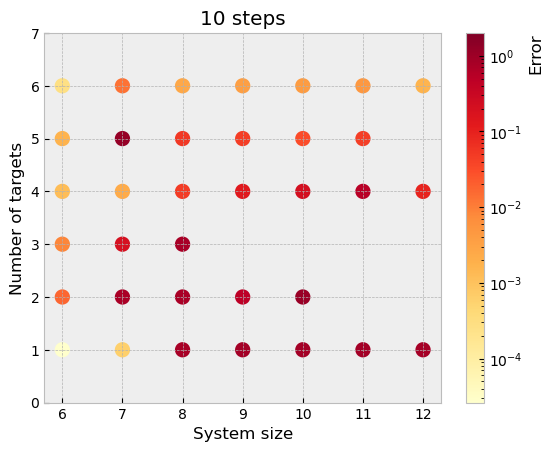

In [521]:
Nlist = [6, 7, 8, 9, 10, 11, 12]

fig, ax = plt.subplots(1, 1)

sc = ax.scatter(Nlist, Ntargets_1T, c=N_vs_Err_1T_10, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0),  linewidths=5.0, cmap='YlOrRd')
ax.scatter(Nlist[:5], Ntargets_2T[:5],  c=avgErrs_2T_10[:5], norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), linewidths=5.0, cmap='YlOrRd')
ax.scatter(Nlist[:3], Ntargets_3T[:3],  c=avgErrs_3T_10[:3], norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), linewidths=5.0, cmap='YlOrRd')
ax.scatter(Nlist, Ntargets_4T,  c=avgErrs_4T_10, linewidths=5.0, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), cmap='YlOrRd')
ax.scatter(Nlist[:6], Ntargets_5T[:6],  c=avgErrs_5T_10[:6], linewidths=5.0, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), cmap='YlOrRd')
ax.scatter(Nlist, Ntargets_6T,  c=avgErrs_6T_10, linewidths=5.0, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), cmap='YlOrRd')
ax.set_xlabel('System size')
ax.set_ylim(0.0, 7.0)
ax.set_ylabel('Number of targets')
ax.set_title("10 learning steps")
cbar = fig.colorbar(sc)
cbar.set_label("Error", loc='top')
# ax.scatter()

[1.1079e-03 2.1095e+00 1.3859e-02 1.1257e-02 1.4962e-02]
[5, 5, 5, 5, 5, 5, 5]
[6, 7, 9, 10, 11]


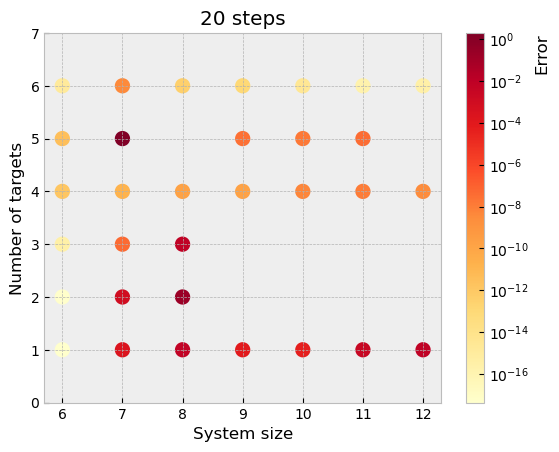

In [523]:
fig, ax = plt.subplots(1, 1)
Nlist5T = [6, 7, 9, 10, 11]

print(avgErrs_5T_20)
print(Ntargets_5T)
print(Nlist5T)

sc = ax.scatter(Nlist, Ntargets_1T, c=N_vs_Err_1T_20, norm=colors.LogNorm(vmin=N_vs_Err_1T_20.min(), vmax=2.0),  linewidths=5.0, cmap='YlOrRd')
ax.scatter(Nlist[:3], Ntargets_2T[:3],  c=avgErrs_2T_20[:3], norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), linewidths=5.0, cmap='YlOrRd')
ax.scatter(Nlist[:3], Ntargets_3T[:3],  c=avgErrs_3T_20[:3], norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), linewidths=5.0, cmap='YlOrRd')
ax.scatter(Nlist, Ntargets_4T,  c=avgErrs_4T_20, linewidths=5.0, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), cmap='YlOrRd')
ax.scatter(Nlist5T[:5], Ntargets_5T[:5],  c=avgErrs_5T_20[:5], linewidths=5.0, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), cmap='YlOrRd')
ax.scatter(Nlist, Ntargets_6T,  c=avgErrs_6T_20, linewidths=5.0, norm=colors.LogNorm(vmin=N_vs_Err_1T_10.min(), vmax=2.0), cmap='YlOrRd')
ax.set_xlabel('System size')
ax.set_ylim(0.0, 7.0)
ax.set_ylabel('Number of targets')
ax.set_title("20 learning steps")
cbar = fig.colorbar(sc)
cbar.set_label("Error", loc='top')
# ax.scatter()

[]

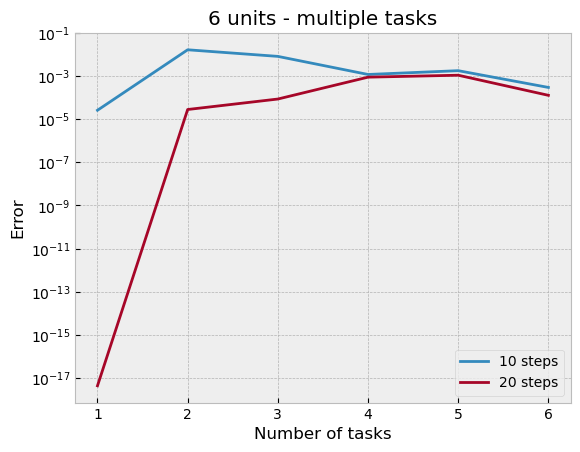

In [534]:
number_of_tasks = [1, 2, 3, 4, 5, 6]
Error_10steps = [2.6161e-05, 0.0168, 0.0083, 0.0012, 0.0018, 0.0003]
Error_20steps = [4.2347e-18, 2.8353e-05, 8.6892e-05, 0.0009, 1.1079e-03, 1.2916e-04]

plt.plot(number_of_tasks, Error_10steps, label='10 steps')
plt.plot(number_of_tasks, Error_20steps, label='20 steps')
plt.legend()

plt.xlabel('Number of tasks')
plt.ylabel('Error')
plt.title('6 units - multiple tasks')

plt.semilogy()